In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsaplots

# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px

from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler


C:\Users\minhh\AppData\Local\Temp\ipykernel_20332\21078125.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
df=pd.read_csv('../Dataset/GVR Historical Data.csv')

In [3]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/02/2023,"18,900","18,950","19,000","18,600",2.72M,0.53%
1,06/01/2023,"18,800","18,350","18,900","18,100",4.25M,3.30%
2,05/31/2023,"18,200","18,450","18,450","18,000",3.14M,-1.09%
3,05/30/2023,"18,400","18,300","18,500","17,850",4.58M,1.10%
4,05/29/2023,"18,200","17,200","18,200","17,050",6.08M,5.81%
...,...,...,...,...,...,...,...
1287,03/28/2018,"11,327","10,736","11,622","10,637",139.80K,5.50%
1288,03/27/2018,"10,736","10,637","10,834","10,342",52.20K,5.83%
1289,03/26/2018,"10,145","10,046","10,342","10,046",267.80K,-1.90%
1290,03/23/2018,"10,342","10,440","10,440","9,849",111.80K,-3.67%


In [4]:
# Checking null value
df.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [5]:
df.dtypes

Date        object
Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object

In [6]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [7]:
tranformData(df)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-06-02,18900.0,18950.0,19000.0,18600.0,2720000.0,0.0053
1,2023-06-01,18800.0,18350.0,18900.0,18100.0,4250000.0,0.0330
2,2023-05-31,18200.0,18450.0,18450.0,18000.0,3140000.0,-0.0109
3,2023-05-30,18400.0,18300.0,18500.0,17850.0,4580000.0,0.0110
4,2023-05-29,18200.0,17200.0,18200.0,17050.0,6080000.0,0.0581
...,...,...,...,...,...,...,...
1287,2018-03-28,11327.0,10736.0,11622.0,10637.0,139800.0,0.0550
1288,2018-03-27,10736.0,10637.0,10834.0,10342.0,52200.0,0.0583
1289,2018-03-26,10145.0,10046.0,10342.0,10046.0,267800.0,-0.0190
1290,2018-03-23,10342.0,10440.0,10440.0,9849.0,111800.0,-0.0367


In [8]:
df=df.sort_values(['Date'], ascending=[True])
df = df.reset_index(drop=True)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2018-03-22,10736.0,10834.0,11130.0,10046.0,260800.0,0.0000
1,2018-03-23,10342.0,10440.0,10440.0,9849.0,111800.0,-0.0367
2,2018-03-26,10145.0,10046.0,10342.0,10046.0,267800.0,-0.0190
3,2018-03-27,10736.0,10637.0,10834.0,10342.0,52200.0,0.0583
4,2018-03-28,11327.0,10736.0,11622.0,10637.0,139800.0,0.0550
...,...,...,...,...,...,...,...
1287,2023-05-29,18200.0,17200.0,18200.0,17050.0,6080000.0,0.0581
1288,2023-05-30,18400.0,18300.0,18500.0,17850.0,4580000.0,0.0110
1289,2023-05-31,18200.0,18450.0,18450.0,18000.0,3140000.0,-0.0109
1290,2023-06-01,18800.0,18350.0,18900.0,18100.0,4250000.0,0.0330


In [9]:
df.describe()

,Price,Open,High,Low,Vol.,Change %
count,1292.000000,1292.00000,1292.000000,1292.000000,1.292000e+03,1292.000000
mean,18318.022446,18331.44582,18721.491486,17966.616873,2.053196e+06,0.000922
std,9337.694144,9357.29766,9544.342849,9185.488125,2.092621e+06,0.031147
min,6796.000000,7190.00000,7683.000000,6599.000000,3.000000e+02,-0.137600
25%,11122.500000,11100.00000,11400.000000,10834.000000,3.637350e+05,-0.014725
50%,14200.000000,14250.00000,14506.000000,13914.000000,1.430000e+06,0.000000
75%,25031.000000,25055.25000,25579.000000,24410.250000,2.985000e+06,0.017675
max,41004.000000,42173.00000,42173.000000,39738.000000,1.585000e+07,0.168500


In [10]:
fig = px.line(df, x=df.Date, y=df.Price,labels={'Date':'Date','Price':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price for chart of GVR', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [11]:
# Tính số lượng mẫu trong tập huấn luyện, tập kiểm tra
train_size = int(len(df) * 0.6)
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

# Chia dữ liệu thành tập huấn luyện, tập kiểm tra
df=df['Price']

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
# In số lượng mẫu trong mỗi tập dữ liệu
print("Số lượng mẫu trong tập huấn luyện: ", train_data.shape)
print("Số lượng mẫu trong tập kiểm tra: ", test_data.shape)
print("Số lượng mẫu trong tập valid: ", val_data.shape)

Số lượng mẫu trong tập huấn luyện:  (775,)
Số lượng mẫu trong tập kiểm tra:  (258,)
Số lượng mẫu trong tập valid:  (259,)


In [12]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# #Test for staionarity
# def test_stationarity(timeseries):
#     #Determing rolling statistics
#     rolmean = timeseries.rolling(12).mean()
#     rolstd = timeseries.rolling(12).std()
#     #Plot rolling statistics:
#     plt.plot(timeseries, color='blue',label='Original')
#     plt.plot(rolmean, color='red', label='Rolling Mean')
#     plt.plot(rolstd, color='black', label = 'Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean and Standard Deviation')
#     plt.show(block=False)
    
#     print("Results of dickey fuller test")
#     adft = adfuller(timeseries,autolag='AIC')
#     # output for dft will give us without defining what the values are.
#     #hence we manually write what values does it explains using a for loop
#     output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
#     for key,values in adft[4].items():
#         output['critical value (%s)'%key] =  values
#     print(output)

In [13]:
# test_stationarity(train_data)

In [14]:
# train_data_diff = train_data.diff().dropna()
# test_stationarity(train_data_diff)

In [15]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# acf_original = plot_acf(train_data_diff)

# pacf_original = plot_pacf(train_data_diff)

In [16]:
from pmdarima.arima import auto_arima
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data)
model=auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
# model = auto_arima(y_train, start_p=0, start_q=0,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=20, max_q=20, # maximum p and q
#                       m=1,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=False, 
#                       stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11685.253, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11707.892, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11688.725, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11684.387, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11706.945, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11681.618, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11683.613, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11683.621, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11682.110, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11684.266, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=11680.331, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=11683.077, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=11687.423, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=11682.328, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0

In [17]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data)
y_pred_val =  model.predict(n_periods=len(y_val))

In [18]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[24025.05043345 24018.86598184 24021.10917653 24020.29553569
 24020.5906556  24020.48361112 24020.52243778 24020.50835476
 24020.51346288 24020.51161009 24020.51228213 24020.51203837
 24020.51212678 24020.51209471 24020.51210635 24020.51210213
 24020.51210366 24020.5121031  24020.5121033  24020.51210323
 24020.51210326 24020.51210325 24020.51210325 24020.51210325
 24020.51210325 24020.51210325 24020.51210325 24020.51210325
 24020.51210325 24020.51210325]


In [19]:
# last_date=val_data.index[-1]
# forecast_dates = pd.date_range(last_date, periods=30, freq='D')[1:]
# forecast_df = pd.DataFrame([(date, 0) for date in forecast_dates], columns=['Date', 'Close'])

# # Predict the closing prices for the next 30 days
# y_next_30_days = model.predict(n_periods=len(forecast_df))

# # Print the predicted closing prices for the next 30 days
# print('Predicted closing prices for the next 30 days:')
# print(y_next_30_days)

In [20]:
# for i in range(len(forecast_df)):
#     forecast_df.loc[i, 'Close'] = y_next_30_days[i]

In [21]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error


vail_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', vail_mape)
print('Testing MAPE:', test_mape)


Validation RMSE: 7339.2405888697585
Testing RMSE: 10305.520774199882
Validation MAPE: 0.41237829326978287
Testing MAPE: 0.27246887980640155


Validation RMSE: 7339.2405888697585
Testing RMSE: 10305.520774199882


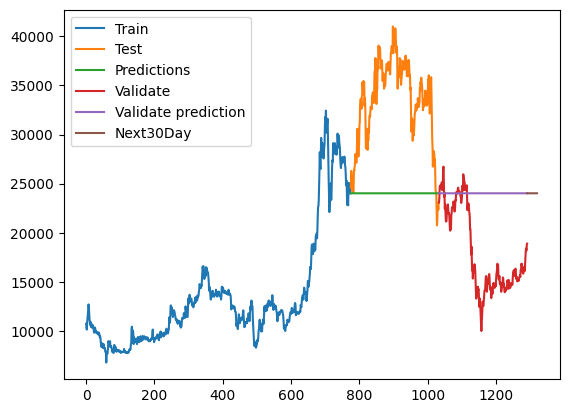

In [22]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Validate prediction','Next30Day'])
plt.show()

In [23]:
x_train = df.index.to_numpy()
y_train = values_array = df.values
model=auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=20241.464, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20246.206, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20236.257, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20236.248, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20244.343, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20238.210, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=20238.201, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20240.212, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=20234.354, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=20236.315, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=20236.300, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=20234.360, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=20238.314, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.787 seconds
         

In [24]:
# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[18903.90234278 18903.90234278 18903.90234278 18903.90234278
 18903.90234278 18903.90234278 18903.90234278 18903.90234278
 18903.90234278 18903.90234278 18903.90234278 18903.90234278
 18903.90234278 18903.90234278 18903.90234278 18903.90234278
 18903.90234278 18903.90234278 18903.90234278 18903.90234278
 18903.90234278 18903.90234278 18903.90234278 18903.90234278
 18903.90234278 18903.90234278 18903.90234278 18903.90234278
 18903.90234278 18903.90234278]


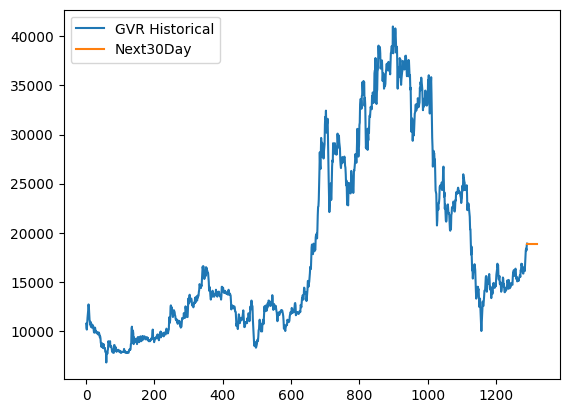

In [25]:
plt.plot(df.index, df.values)
plt.plot(last_data,y_next_30_days)
plt.legend(['GVR Historical', 'Next30Day'])
plt.show()